# Atlas-level integration of lung data

An important task of single-cell analysis is the integration of several samples, which we can perform with scVI. For integration, scVI treats the data as unlabelled. When our dataset is fully labelled (perhaps in independent studies, or independent analysis pipelines), we can obtain an integration that better preserves biology using scANVI, which incorporates cell type annotation information. Here we demonstrate this functionality with an integrated analysis of cells from the lung atlas integration task from the [scIB manuscript](https://www.biorxiv.org/content/10.1101/2020.05.22.111161v2). The same pipeline would generally be used to analyze any collection of scRNA-seq datasets.


In [1]:
import sys

#if branch is stable, will install via pypi, else will install from source
#branch = "stable"
#IN_COLAB = "google.colab" in sys.modules

#if IN_COLAB and branch == "stable":
 #   !pip install --quiet scvi-tools[tutorials]
  #  !pip install --quiet git+https://github.com/theislab/scib.git
#elif IN_COLAB and branch != "stable":
 #   !pip install --quiet --upgrade jsonschema
  #  !pip install --quiet git+https://github.com/yoseflab/scvi-tools@$branch#egg=scvi-tools[tutorials]
   # !pip install --quiet git+https://github.com/theislab/scib.git

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import scanpy as sc
import scvi
#import scib

sc.set_figure_params(figsize=(4, 4))

Global seed set to 0


In [3]:
adata = sc.read("fc_epi.h5ad")

Note that this dataset has the counts already separated in a layer. Here, `adata.X` contains log transformed scran normalized expression.

In [4]:
adata

AnnData object with n_obs × n_vars = 65036 × 27656
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'RNA_snn_res.0.15', 'seurat_clusters', 'costum_clustering', 'Condition', 'pANN_0.25_0.06_1806', 'DF.classifications_0.25_0.06_1806', 'pANN_0.25_0.005_1289', 'DF.classifications_0.25_0.005_1289', 'RNA_snn_res.0.1', 'pANN_0.25_0.18_1347', 'DF.classifications_0.25_0.18_1347', 'pANN_0.25_0.14_831', 'DF.classifications_0.25_0.14_831', 'batch'
    var: 'features'

In [5]:
#sc.pp.log1p(adata)
adata

AnnData object with n_obs × n_vars = 65036 × 27656
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'RNA_snn_res.0.15', 'seurat_clusters', 'costum_clustering', 'Condition', 'pANN_0.25_0.06_1806', 'DF.classifications_0.25_0.06_1806', 'pANN_0.25_0.005_1289', 'DF.classifications_0.25_0.005_1289', 'RNA_snn_res.0.1', 'pANN_0.25_0.18_1347', 'DF.classifications_0.25_0.18_1347', 'pANN_0.25_0.14_831', 'DF.classifications_0.25_0.14_831', 'batch'
    var: 'features'

### Dataset preprocessing

This dataset was already processed as described in the scIB manuscript. Generally, models in scvi-tools expect data that has been filtered/aggregated in the same fashion as one would do with Scanpy/Seurat.


Another important thing to keep in mind is highly-variable gene selection. While scVI and scANVI both accomodate using all genes in terms of runtime, we usually recommend filtering genes for best integration performance. This will, among other things, remove batch-specific variation due to batch-specific gene expression.

We perform this gene selection using the Scanpy pipeline while keeping the full dimension normalized data in the `adata.raw` object. We obtain variable genes from each dataset and take their intersections. 

In [6]:
adata.raw = adata  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata, 
    flavor="seurat_v3", 
    n_top_genes=2000, 
    layer=None,  # "counts" in original
    batch_key="batch",
    subset=True
)

/vol/mbconda/julian/envs/scVItools/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


<div class="alert alert-info">

Important

We see a warning about the data not containing counts. This is due to some of the samples in this dataset containing SoupX-corrected counts. scvi-tools models will run for non-negative real-valued data, but we strongly suggest checking that these possibly non-count values are intended to represent pseudocounts, and not some other normalized data, in which the variance/covariance structure of the data has changed dramatically.

</div>

## Integration with scVI

As a first step, we assume that the data is completely unlabelled and we wish to find common axes of variation between the two datasets. There are many methods available in scanpy for this purpose (BBKNN, Scanorama, etc.). In this notebook we present scVI. To run scVI, we simply need to:

* Register the AnnData object with the correct key to identify the sample and the layer key with the count data.
* Create an SCVI model object.

In [7]:
scvi.model.SCVI.setup_anndata(adata, layer=None, batch_key="batch") #layer="counts" in original

INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 65036 cells, 2000 vars, 4 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


We note that these parameters are non-default; however, they have been verified to generally work well in the integration task.

In [8]:
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")

/vol/mbconda/julian/envs/scVItools/lib/python3.9/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


Now we train scVI. This should take a couple of minutes on a Colab session

In [9]:
vae.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 123/123: 100%|█████████████████████████████████████████████████████████████████████████████████████| 123/123 [20:17<00:00,  9.90s/it, loss=386, v_num=1]


Once the training is done, we can evaluate the latent representation of each cell in the dataset and add it to the AnnData object

In [10]:
adata.obsm["X_scVI"] = vae.get_latent_representation()

/vol/mbconda/julian/envs/scVItools/lib/python3.9/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


In [11]:
adata.write_h5ad("fc_epi_scVI.h5ad")

/vol/mbconda/julian/envs/scVItools/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'orig.ident' as categorical
/vol/mbconda/julian/envs/scVItools/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Phase' as categorical
/vol/mbconda/julian/envs/scVItools/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed i

In [12]:
#Add cluster labeling to the adata object in obs
sc.pp.neighbors(adata, use_rep="X_scVI")
for i in range(20):
    res = i/20
    print("Running with leiden clustering with current resolution:")
    print(res)
    lst = ["leiden_",str(res)]
    cluster_variable_name = ''.join(lst)
    sc.tl.leiden(adata,resolution=res)
    adata.obs[cluster_variable_name] = adata.obs['leiden']

Running with leiden clustering with current resolution:
0.0
Running with leiden clustering with current resolution:
0.05
Running with leiden clustering with current resolution:
0.1
Running with leiden clustering with current resolution:
0.15
Running with leiden clustering with current resolution:
0.2
Running with leiden clustering with current resolution:
0.25
Running with leiden clustering with current resolution:
0.3
Running with leiden clustering with current resolution:
0.35
Running with leiden clustering with current resolution:
0.4
Running with leiden clustering with current resolution:
0.45
Running with leiden clustering with current resolution:
0.5
Running with leiden clustering with current resolution:
0.55
Running with leiden clustering with current resolution:
0.6
Running with leiden clustering with current resolution:
0.65
Running with leiden clustering with current resolution:
0.7
Running with leiden clustering with current resolution:
0.75
Running with leiden clustering w

In [13]:
adata.write_h5ad("fc_epi_scVI_leiden_res.h5ad")

Finally, we can cluster the dataset and visualize it with UMAP

In [3]:
from invoke import run
from os import path
adata = sc.read("fc_epi_scVI_leiden_res.h5ad")

In [15]:
CLUSTREE_SCRIPT = "/ceph/rimlsfnwi/data/moldevbio/zhou/jarts/jupyter_notebooks/CLUSTREE_SCRIPT.R"
ADATA_PATH = "/ceph/rimlsfnwi/data/moldevbio/zhou/jarts/jupyter_notebooks/fc_epi_scVI_leiden_res.h5ad"
OUT_PATH = "/ceph/rimlsfnwi/data/moldevbio/zhou/jarts/jupyter_notebooks/CLUSTREE_OUT_14022022/clustree.png"

In [16]:
# check the optimal clustering resolution based on clustree
singler_run_clusters = run(f"Rscript {CLUSTREE_SCRIPT} {ADATA_PATH} {OUT_PATH}")

H5AD_PATH: /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/jupyter_notebooks/fc_epi_scVI_leiden_res.h5ad
OUT_PATH: /ceph/rimlsfnwi/data/moldevbio/zhou/jarts/jupyter_notebooks/CLUSTREE_OUT_14022022/clustree.png
$width
[1] 10

$height
[1] 12.6

AnnData object with n_obs × n_vars = 65036 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'RNA_snn_res.0.15', 'seurat_clusters', 'costum_clustering', 'Condition', 'pANN_0.25_0.06_1806', 'DF.classifications_0.25_0.06_1806', 'pANN_0.25_0.005_1289', 'DF.classifications_0.25_0.005_1289', 'RNA_snn_res.0.1', 'pANN_0.25_0.18_1347', 'DF.classifications_0.25_0.18_1347', 'pANN_0.25_0.14_831', 'DF.classifications_0.25_0.14_831', 'batch', '_scvi_batch', '_scvi_labels', 'leiden', 'leiden_0.0', 'leiden_0.05', 'leiden_0.1', 'leiden_0.15', 'leiden_0.2', 'leiden_0.25', 'leiden_0.3', 'leiden_0.35', 'leiden_0.4', 'leiden_0.45', 'leiden_0.5', 'leiden_0.55', 'leiden_0.6', 'leiden_0.65', 'leiden_0.7', '

Warning messages:
1: The following metadata column names will be converted from:
_scvi_batch, _scvi_labels
to:
X_scvi_batch, X_scvi_labels 
2: The `add` argument of `group_by()` is deprecated as of dplyr 1.0.0.
Please use the `.add` argument instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated. 


In [4]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.leiden(adata,resolution=0.35)
sc.tl.umap(adata)

In [5]:
# Save the labeling of the cells to a tsv file for import back in the seurat object
df = pd.DataFrame(data=adata.obs['leiden'])
df.to_csv("scVI_leiden_clusters_fc_epi_0.35_20072022.tsv", sep="\t", index=True,header=False)
df

,leiden
Collin_SRR12386359_AAACGAACAAGTTCGT-1,0
Collin_SRR12386359_AAACGAACATCAGTGT-1,0
Collin_SRR12386359_AAACGAATCGCCTTTG-1,0
Collin_SRR12386359_AAACGAATCTCGCTTG-1,4
Collin_SRR12386359_AAACGCTAGCCTATTG-1,3
...,...
Gautam_SRR14742511_TTTGGTTTCCGTAGGC-1,13
Gautam_SRR14742511_TTTGTTGAGGATGTTA-1,6
Gautam_SRR14742511_TTTGTTGCAGCCATTA-1,6
Gautam_SRR14742511_TTTGTTGTCCTATTTG-1,6


In [6]:
# Give the new names based on marker genes from Seurat marker gene analysis (raw data) to the clusters
labels = pd.read_csv("/ceph/rimlsfnwi/data/moldevbio/zhou/jarts/R/scRNA-seq_integrated_cornea_4_datasets/20220228/labels_4datasets.csv", header=0,index_col=None, sep=',')

In [7]:
adata

AnnData object with n_obs × n_vars = 65036 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'RNA_snn_res.0.15', 'seurat_clusters', 'costum_clustering', 'Condition', 'pANN_0.25_0.06_1806', 'DF.classifications_0.25_0.06_1806', 'pANN_0.25_0.005_1289', 'DF.classifications_0.25_0.005_1289', 'RNA_snn_res.0.1', 'pANN_0.25_0.18_1347', 'DF.classifications_0.25_0.18_1347', 'pANN_0.25_0.14_831', 'DF.classifications_0.25_0.14_831', 'batch', '_scvi_batch', '_scvi_labels', 'leiden', 'leiden_0.0', 'leiden_0.05', 'leiden_0.1', 'leiden_0.15', 'leiden_0.2', 'leiden_0.25', 'leiden_0.3', 'leiden_0.35', 'leiden_0.4', 'leiden_0.45', 'leiden_0.5', 'leiden_0.55', 'leiden_0.6', 'leiden_0.65', 'leiden_0.7', 'leiden_0.75', 'leiden_0.8', 'leiden_0.85', 'leiden_0.9', 'leiden_0.95'
    var: 'features', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi', 'hvg', 'leiden', 

In [8]:
df = pd.DataFrame(data=adata.obs['batch'])
labels.index = df.index
labels.columns = ['leiden']
labels

,leiden
Collin_SRR12386359_AAACGAACAAGTTCGT-1,Cj
Collin_SRR12386359_AAACGAACATCAGTGT-1,Cj
Collin_SRR12386359_AAACGAATCGCCTTTG-1,Cj
Collin_SRR12386359_AAACGAATCTCGCTTG-1,CSSC
Collin_SRR12386359_AAACGCTAGCCTATTG-1,LESC
...,...
Gautam_SRR14742511_TTTGGTTTCCGTAGGC-1,CF
Gautam_SRR14742511_TTTGTTGAGGATGTTA-1,LSC
Gautam_SRR14742511_TTTGTTGCAGCCATTA-1,LSC
Gautam_SRR14742511_TTTGTTGTCCTATTTG-1,LSC


In [9]:
adata.obs['leiden_anno'] = labels

In [10]:
labels

,leiden
Collin_SRR12386359_AAACGAACAAGTTCGT-1,Cj
Collin_SRR12386359_AAACGAACATCAGTGT-1,Cj
Collin_SRR12386359_AAACGAATCGCCTTTG-1,Cj
Collin_SRR12386359_AAACGAATCTCGCTTG-1,CSSC
Collin_SRR12386359_AAACGCTAGCCTATTG-1,LESC
...,...
Gautam_SRR14742511_TTTGGTTTCCGTAGGC-1,CF
Gautam_SRR14742511_TTTGTTGAGGATGTTA-1,LSC
Gautam_SRR14742511_TTTGTTGCAGCCATTA-1,LSC
Gautam_SRR14742511_TTTGTTGTCCTATTTG-1,LSC


In [30]:
# Optimal resolution 0.35
adata.obs["leiden_anno"]=adata.obs["leiden_anno"].astype('category')
adata.obs["leiden_anno"].cat.reorder_categories(["LSC","LESC","LE","Cj","CE","CSSC","SK","CF","TSK","EC","Ves","Mel","IC","MF","CDH19+"], inplace=True)

/scratch/julian/tmp/VIhf/ipykernel_95009/2079139789.py:3: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata.obs["leiden_anno"].cat.reorder_categories(["LSC","LESC","LE","Cj","CE","CSSC","SK","CF","TSK","EC","Ves","Mel","IC","MF","CDH19+"], inplace=True)


In [31]:
# Save the new object
adata.write_h5ad("20072022/fullcornea_scVI_postprocessing.h5ad")

In [32]:
adata=sc.read("fullcornea_scVI_postprocessing.h5ad")

# Plotting the cells

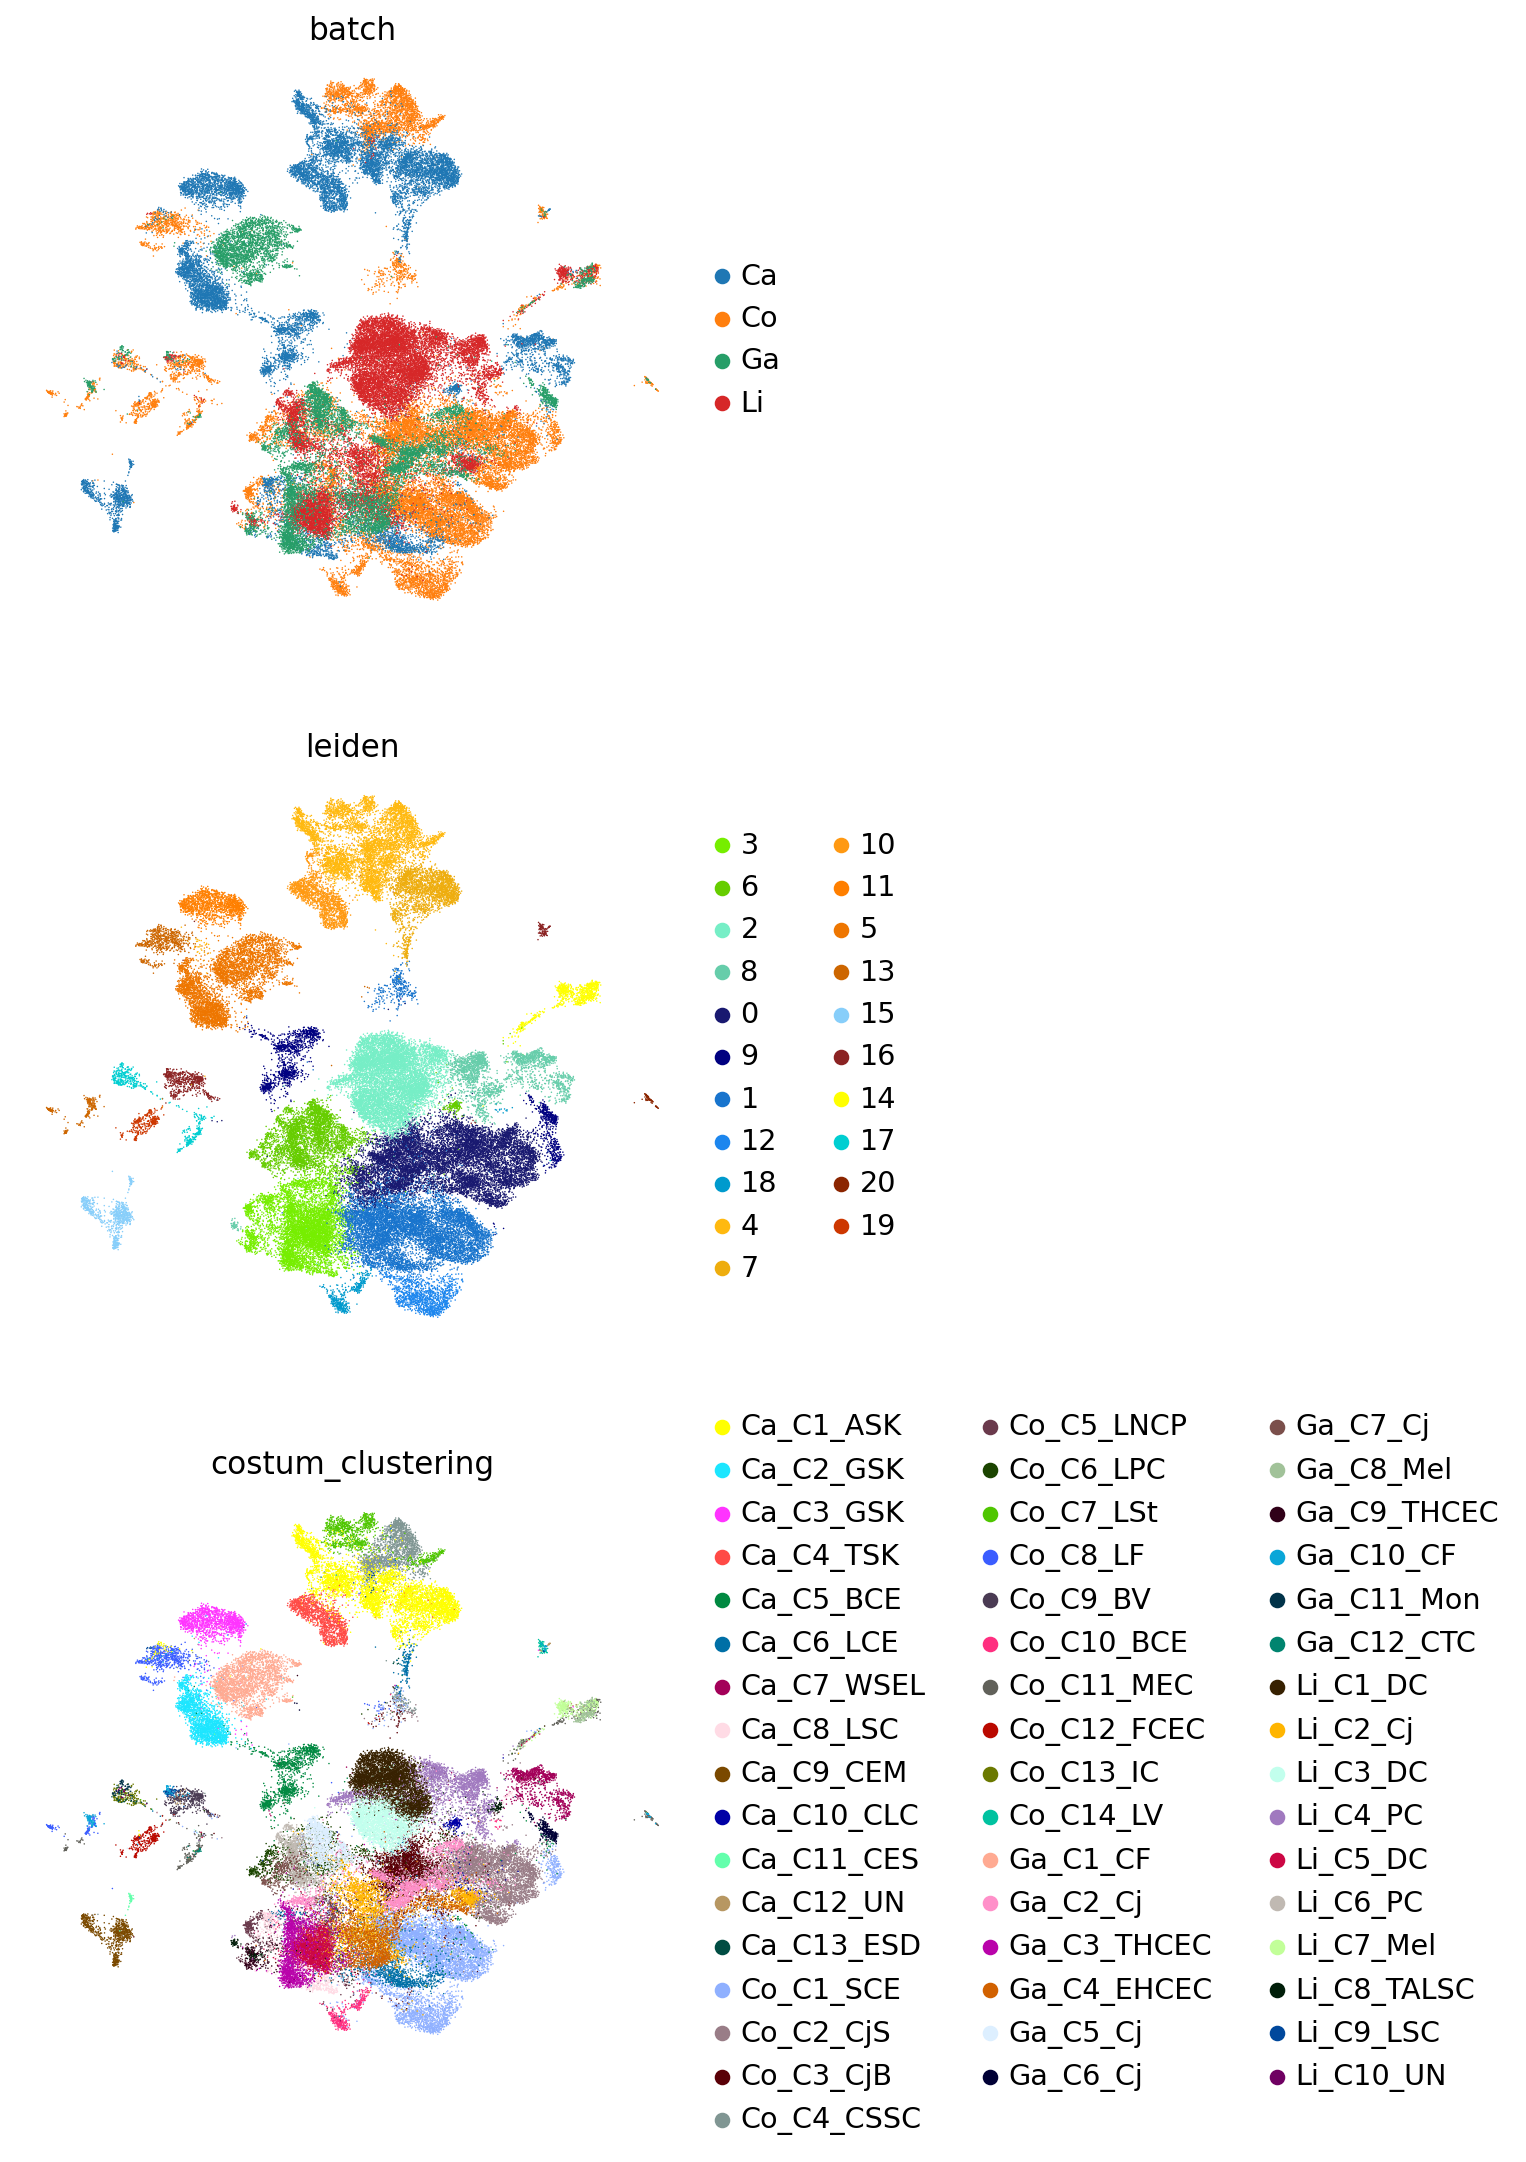

In [33]:
# batches and clusters on 0.35 resolution
sc.set_figure_params(figsize=(5, 5))
sc.pl.umap(
    adata, 
    color=["batch","leiden","costum_clustering"], 
    frameon=False, 
    ncols=1, 
)

/scratch/julian/tmp/VIhf/ipykernel_95009/43589236.py:2: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata.obs['leiden'].cat.reorder_categories(["6","3","2","8","0","9","1","12","18","4","7","10","11","5","13","15","16","14","17","20","19"], inplace=True)


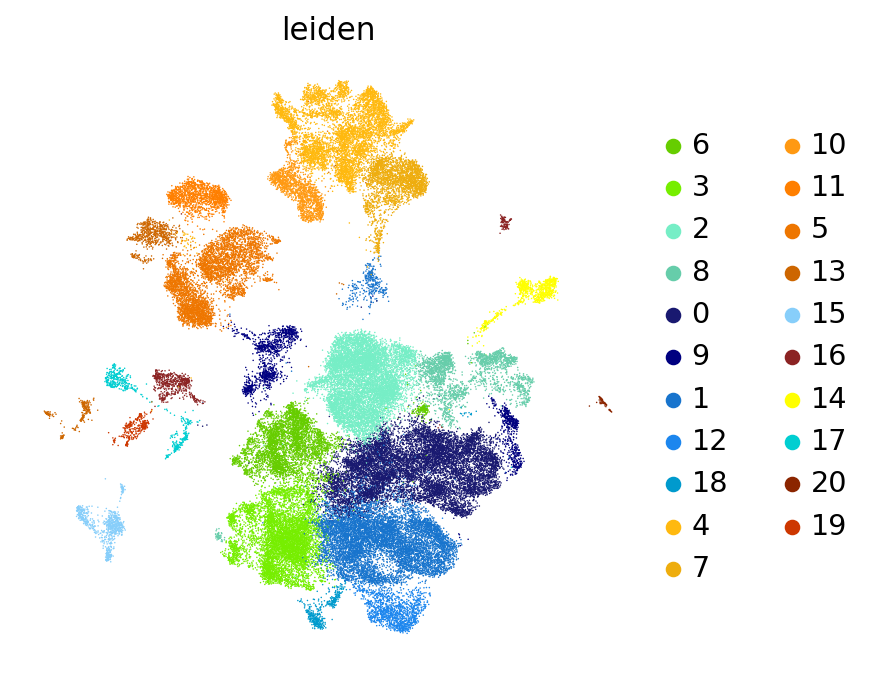

In [34]:
# Optimal resolution 0.35
adata.obs['leiden'].cat.reorder_categories(["6","3","2","8","0","9","1","12","18","4","7","10","11","5","13","15","16","14","17","20","19"], inplace=True)

sc.set_figure_params(figsize=(5, 5))
sc.pl.umap(
    adata, 
    color=["leiden"], 
    frameon=False, 
    ncols=1,
    palette={
        "6": "#66CD00",
        "3": "#76EE00",
        "2": "#76EEC6",
        "8": "#66CDAA",
        "0": "#191970",
        "9": "#000080",
        "1": "#1874CD",
        "12": "#1C86EE",
        "18": "#009ACD",
        "4": "#FFB90F",
        "7": "#EEAD0E",
        "10": "#FF9912",
        "11": "#FF7F00",
        "5": "#EE7600",
        "13": "#CD6600",
        "15": "#87CEFA",
        "16": "#8B2323",
        "14": "#FFFF00",
        "17": "#00CED1",
        "20": "#8B2500",
        "19": "#CD3700",
    },
)    

In [35]:
# Optimal resolution 0.35
adata.obs['leiden'] = adata.obs['leiden'].cat.rename_categories({"6": "6: LSC",
        "3": "3: LESC",
        "2": "2: LE",
        "8": "8: LE",
        "0": "0: Cj",
        "9": "9: Cj",
        "1": "1: CE",
        "12": "12: CE",
        "18": "18: CE",
        "4": "4: CSSC",
        "7": "7: SK",
        "10": "10: SK",
        "11": "11: TSK",
        "5": "5: CF",
        "13": "13: CF",
        "15": "15: EC",
        "16": "16: Ves",
        "14": "14: Mel",
        "17": "17: IC",
        "20": "20: MF",
        "19": "19: CDH19+",
    })

In [36]:
# Set PDF printing for the co-embedded UMAP
sc.set_figure_params(scanpy=True, dpi=400, dpi_save=400, frameon=True, vector_friendly=True, fontsize=14, figsize=None, color_map=None, format='pdf', facecolor=None, transparent=False, ipython_format='png2x')

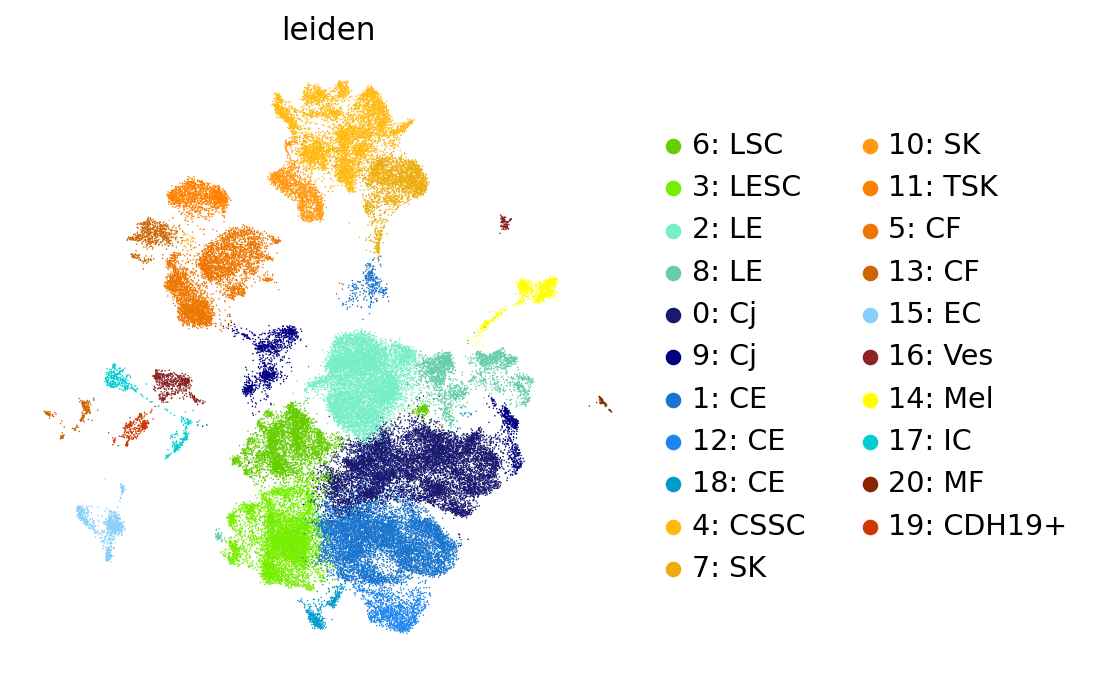

In [37]:
# Optimal resolution 0.35
sc.set_figure_params(figsize=(5, 5))
sc.pl.umap(
    adata, 
    color=["leiden"], 
    frameon=False, 
    ncols=1,
    palette={
        "6: LSC": "#66CD00",
        "3: LESC": "#76EE00",
        "2: LE": "#76EEC6",
        "8: LE": "#66CDAA",
        "0: Cj": "#191970",
        "9: Cj": "#000080",
        "1: CE": "#1874CD",
        "12: CE": "#1C86EE",
        "18: CE": "#009ACD",
        "4: CSSC": "#FFB90F",
        "7: SK": "#EEAD0E",
        "10: SK": "#FF9912",
        "11: TSK": "#FF7F00",
        "5: CF": "#EE7600",
        "13: CF": "#CD6600",
        "15: EC": "#87CEFA",
        "16: Ves": "#8B2323",
        "14: Mel": "#FFFF00",
        "17: IC": "#00CED1",
        "20: MF": "#8B2500",
        "19: CDH19+": "#CD3700",
    },save='_meta_named.pdf')

In [15]:
# Give the leiden cluster IDs of integrated data to adata_raw for correct import and downstream analysis in R
adata_raw = adata
adata_raw.obs['scVI_leiden_clusters'] = adata.obs['leiden']

In [24]:
df = pd.DataFrame(data=adata.obs['scVI_leiden_clusters'])
df.to_csv("scVI_leiden_clusters_fullcornea_10022022.tsv", sep="\t", index=True,header=False)
df

,scVI_leiden_clusters
Collin_SRR12386359_AAACGAACAAGTTCGT-1,2
Collin_SRR12386359_AAACGAACATCAGTGT-1,2
Collin_SRR12386359_AAACGAATCGCCTTTG-1,2
Collin_SRR12386359_AAACGAATCTCGCTTG-1,1
Collin_SRR12386359_AAACGCTAGCCTATTG-1,3
...,...
Catala_GSM5651520_TTTGGAGCAGGTAGTG-1,11
Catala_GSM5651520_TTTGGTTAGCGGTATG-1,11
Catala_GSM5651520_TTTGGTTGTACTAAGA-1,11
Catala_GSM5651520_TTTGGTTTCCGCGGAT-1,11


In [4]:
adata.layers['scVI_counts'] = adata.X.copy()

In [17]:
adata

AnnData object with n_obs × n_vars = 38179 × 26822
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'RNA_snn_res.0.15', 'seurat_clusters', 'costum_clustering', 'Condition', 'pANN_0.25_0.06_1806', 'DF.classifications_0.25_0.06_1806', 'pANN_0.25_0.005_1289', 'DF.classifications_0.25_0.005_1289', 'batch', 'scVI_leiden_clusters'
    var: 'features'

In [7]:
adata.write_h5ad("fullcornea_scVI_leiden.h5ad")